In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#regression libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#impoting the data

df = pd.read_csv('/workspaces/First-data-project/Kaggle Project/Data/Cleaned Data/scaled_df.csv')

df.drop('Unnamed: 0', axis=1, inplace=True)

df.head()

,price,grade,sqft_living,lat,sqft_living15,sqft_above,bathrooms,floors,bedrooms,sqft_basement,view
0,1.000000,0.6,0.763077,0.696960,0.672862,0.713805,0.461538,0.50,0.75,0.281250,0.00
1,0.998573,0.8,0.590769,0.672511,0.368030,0.417508,0.769231,0.50,0.75,0.531250,0.25
2,0.997146,0.8,0.532308,0.711597,0.446097,0.582492,0.615385,0.50,0.50,0.000000,0.00
3,0.996707,0.6,0.633846,0.780762,0.639405,0.555556,0.615385,0.50,0.75,0.320312,0.00
4,0.996707,0.6,0.550769,0.807946,0.624535,0.508418,0.615385,0.25,0.50,0.218750,0.00


In [8]:
model=LinearRegression()

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(mean_squared_error(y_test, y_pred))



0.015609087632277412


In [9]:
coeffs = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
coeffs = coeffs.sort_values(by='Coefficient', ascending=False)
print(coeffs)



         Feature  Coefficient
2            lat     0.408932
0          grade     0.316254
9           view     0.182391
1    sqft_living     0.169926
4     sqft_above     0.144229
3  sqft_living15     0.097819
8  sqft_basement     0.096797
6         floors     0.016498
7       bedrooms    -0.029846
5      bathrooms    -0.050938


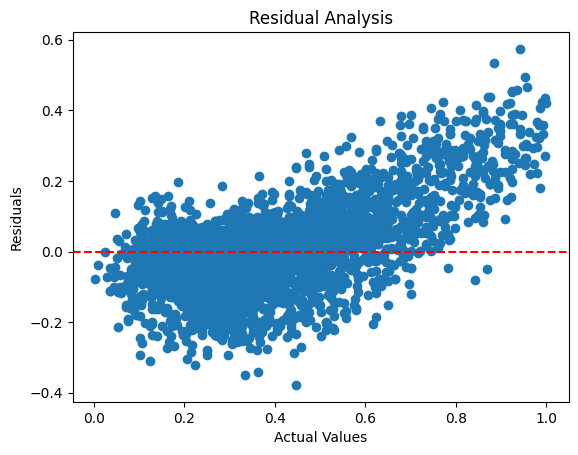

In [10]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()


In [11]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)

# Train a new model with polynomial features
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
model.fit(X_train_poly, y_train)
y_pred_poly = model.predict(X_test_poly)

# Evaluate the new model
print("MSE with Polynomial Features:", mean_squared_error(y_test, y_pred_poly))


MSE with Polynomial Features: 0.0093209823400691


In [12]:
# Evaluate on the training set
y_train_pred_poly = model.predict(X_train_poly)
train_mse = mean_squared_error(y_train, y_train_pred_poly)

# Evaluate on the test set
test_mse = mean_squared_error(y_test, y_pred_poly)

print("Training MSE:", train_mse)
print("Testing MSE:", test_mse)


Training MSE: 0.009290998722388356
Testing MSE: 0.0093209823400691


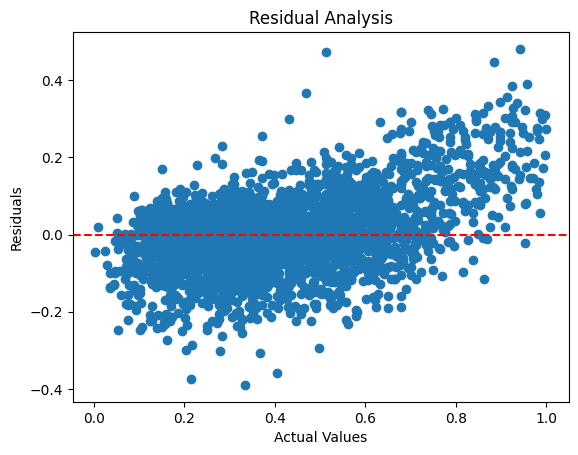

In [13]:
residuals = y_test - y_pred_poly
plt.scatter(y_test, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()


In [14]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_poly, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validation MSE:", -cv_scores.mean())


Cross-Validation MSE: 0.01869227241252466


In [18]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# Initialize the Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42, subsample=0.8)

# Train the model
gbr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gbr = gbr_model.predict(X_test)

# Evaluate the MSE on the test set
test_mse_gbr = mean_squared_error(y_test, y_pred_gbr)
print("Gradient Boosting Test MSE:", test_mse_gbr)

# Cross-Validation
cv_scores_gbr = cross_val_score(gbr_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_gbr = -cv_scores_gbr.mean()
print("Gradient Boosting Cross-Validation MSE:", cv_mse_gbr)


Gradient Boosting Test MSE: 0.006928685447406509
Gradient Boosting Cross-Validation MSE: 0.019674174188269333


In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV MSE:", -grid_search.best_score_)


Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Best CV MSE: 0.007655987229510589


In [19]:
y_pred_final = grid_search.best_estimator_.predict(X_test)
test_mse_final = mean_squared_error(y_test, y_pred_final)
print("Final Test MSE:", test_mse_final)



Final Test MSE: 0.006928685447406509


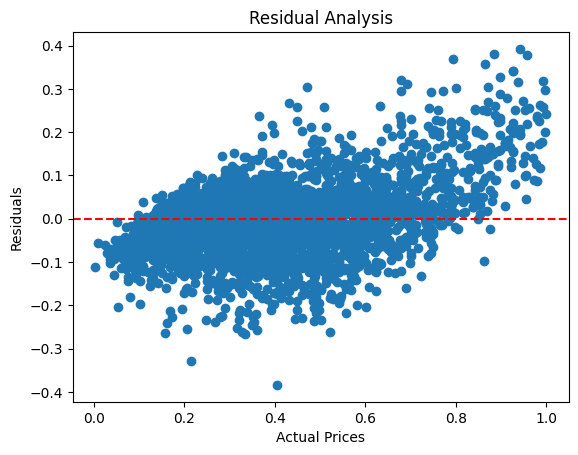

In [20]:
residuals = y_test - y_pred_final
plt.scatter(y_test, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()


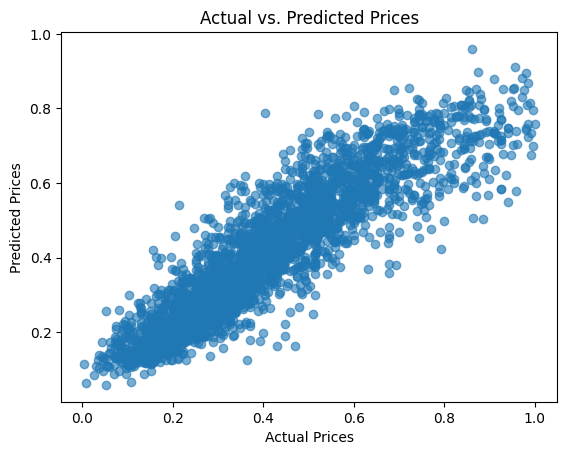

In [26]:
from sklearn.preprocessing import MinMaxScaler

# Assuming this scaler was used earlier
scaler = MinMaxScaler()
scaler.fit(y.values.reshape(-1, 1))  # Fit the scaler on the original y data

# Reverse the scaling
y_test_original = scaler.inverse_transform(y_test.values.reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred_final.reshape(-1, 1))

# Plot Actual vs. Predicted
plt.scatter(y_test_original, y_pred_original, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.show()

